# Стоимость поддержанного автомобиля

**Предсказание стоимости автомобиля на вторичном рынке**

## Описание

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

### Исходные данные

Date: Год выпуска автомобиля.<br/>
Make: Марка автомобиля.<br/>
Model: издание автомобиля определенной марки.<br/>
Trim: Уровни отделки салона автомобиля — это просто разные версии модели.<br/>
Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.<br/>
Transmission: механизм, который передает мощность от двигателя к колесам.<br/>
VIN: идентификационный номер транспортного средства.<br/>
State: штат регистрации автомобиля.<br/>
Condition: Состояние автомобилей на момент аукциона.<br/>
Odometer: расстояние, пройденное автомобилем с момента выпуска.<br/>
Color: Цвет кузова автомобиля.<br/>
Interior: Цвет салона автомобиля.<br/>
Seller: Продавец автомобиля, автосалоны.<br/>
sellingprice: цена, по которой автомобиль был продан на аукционе.<br/>
saledate: Дата продажи автомобиля.<br/>

## Загрузка библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

## EDA

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


Доля объектов с пропуском как минимум в одном признаке - 11,6%

In [6]:
df.describe()

,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


In [7]:
#ProfileReport(df)

### Предобработка данных

#### Количественные признаки

В odometer и sellingprice присутствуют аномальные значения. Попробуем выяснить причину и обработать их

<AxesSubplot: >

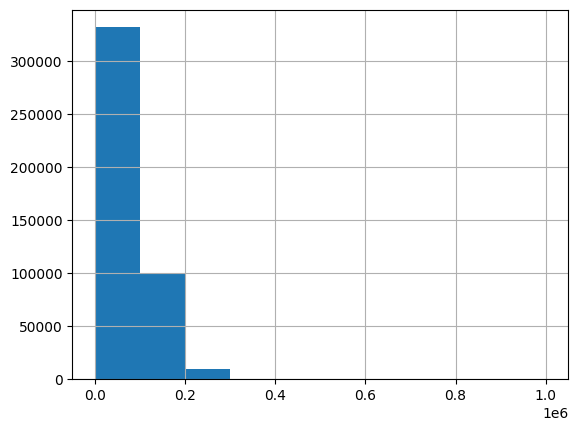

In [8]:
df['odometer'].hist()

<AxesSubplot: >

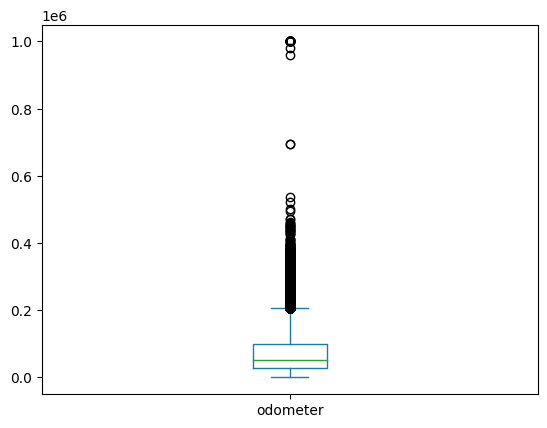

In [9]:
df['odometer'].plot(kind='box')

Присутствует множество аномальных значений (больше 200 000 миль). Сравним объекты с odometer меньше 200 000 и больше 200 000

In [10]:
df.query('odometer > 200_000').describe().compare(df.query('odometer<=200_000').describe())

year                   condition                      odometer  \
              self          other         self          other           self   
count  9698.000000  430469.000000  8999.000000  421812.000000    9698.000000   
mean   2002.677665    2010.206951     2.275964       3.449633  238984.063931   
std       3.831724       3.820226     0.698695       0.939400   68471.936288   
min    1988.000000    1982.000000          NaN            NaN  200001.000000   
25%    2000.000000    2008.000000     1.900000       2.700000  209800.500000   
50%    2003.000000    2012.000000     2.000000       3.600000  223624.000000   
75%    2005.000000    2013.000000     2.700000       4.200000  248280.500000   
max    2014.000000    2015.000000          NaN            NaN  999999.000000   

                      sellingprice                 
               other          self          other  
count  430469.000000   9698.000000  430469.000000  
mean    64500.095412   2511.318313   13843.243425  
std     46421.589879   2629.955026    9707.846609  
min         1.000000    100.000000       1.000000  
25%     27772.000000    800.000000    7300.000000  
50%     50585.000000   1650.000000   12300.000000  
75%     95828.000000   3200.000000   18400.000000  
max    200000.000000  26800.000000  230000.000000

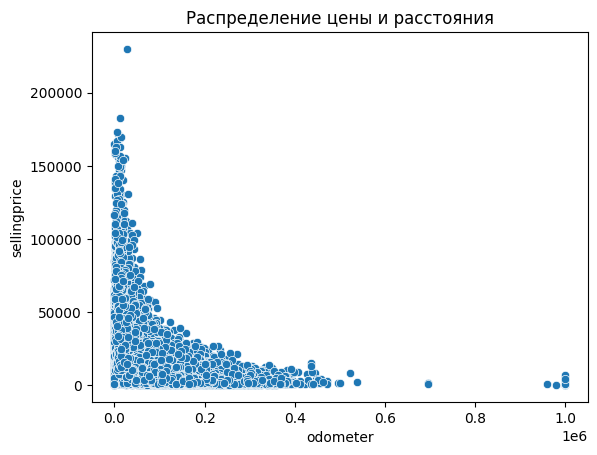

In [11]:
sns.scatterplot(x=df['odometer'],y=df['sellingprice']).set(title='Распределение цены и расстояния');

Посмотрим на объекты, которые не лежат в области с большинством (odometer>600_000). Также стоит посмотреть на объект с целевым признаком больше 200_000

In [12]:
df.query('odometer>600_000').head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
6069,2012,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac6ch429831,oh,1.0,999999.0,white,gray,santander consumer,800,Tue Jan 06 2015 05:00:00 GMT-0800 (PST)
9830,2002,Saturn,VUE,Base,SUV,manual,5gzcz23d52s811182,md,4.7,694978.0,red,beige,autonation chevrolet timonium,1000,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
11122,2004,Chevrolet,Tahoe,LS,SUV,automatic,1gnec13v34j247109,ga,1.9,999999.0,black,tan,santander consumer,1800,Tue Jan 06 2015 01:30:00 GMT-0800 (PST)
12368,2006,Mazda,Tribute,i,SUV,automatic,4f2yz02z26km30632,fl,2.0,999999.0,white,tan,santander consumer,1200,Mon Feb 09 2015 01:30:00 GMT-0800 (PST)
14897,2006,Kia,Amanti,Base,Sedan,automatic,knald124265085150,ms,1.0,999999.0,gray,beige,fiserv/global lending services,800,Thu Dec 18 2014 12:02:00 GMT-0800 (PST)


In [13]:
len(df.query('odometer>600_000'))

59

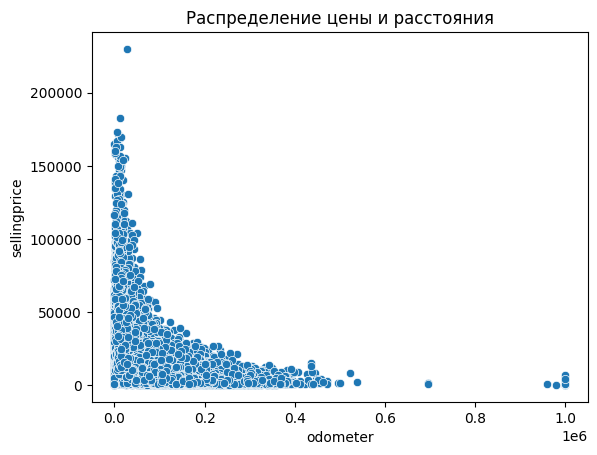

In [14]:
sns.scatterplot(x=df['odometer'],y=df['sellingprice']).set(title='Распределение цены и расстояния');

Возможно значение 999999.0 подставляется в каких то случаях автоматически. Значение 694978.0 также выглядит аномальным. Но так как в общем таких значений очень мало, можно удалить их из датасета

In [15]:
df = df.query('odometer<600_000')

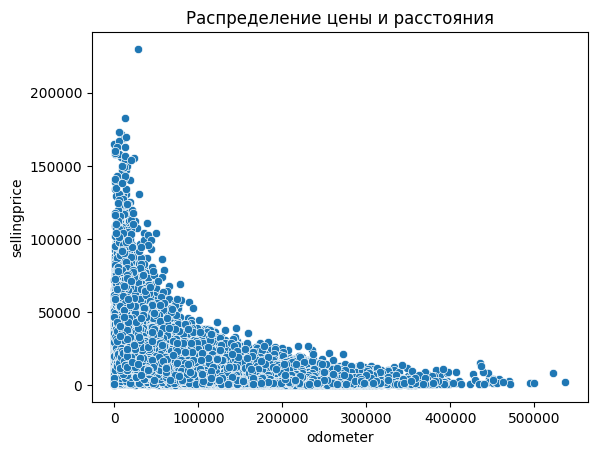

In [16]:
sns.scatterplot(x=df['odometer'],y=df['sellingprice']).set(title='Распределение цены и расстояния');

<AxesSubplot: >

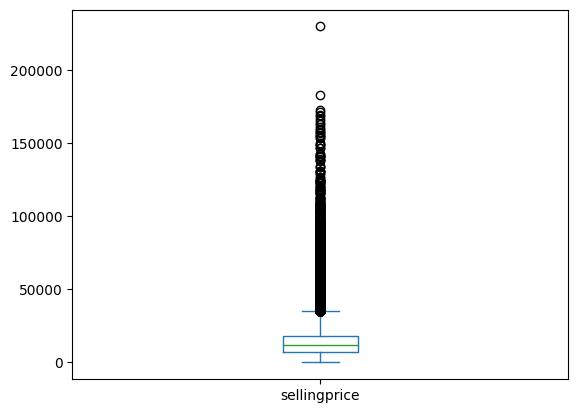

In [17]:
df['sellingprice'].plot(kind='box')

По boxplot можно сказать, что аномальных значений много, однако только одно сильно выделяется среди остальных. В первую очередь стоит обработать его

In [18]:
df.loc[df['sellingprice'].idxmax():df['sellingprice'].idxmax()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
392004,2014,Ford,Escape,Titanium,SUV,automatic,1fmcu9j98eua23833,mo,4.3,27802.0,green,tan,ford-lincoln dealer program,230000,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)


Скорее всего была допущена ошибка в цене. Но так как такое значение всего одно, лучше будет удалить его

In [19]:
df = df.drop(index=df['sellingprice'].idxmax())

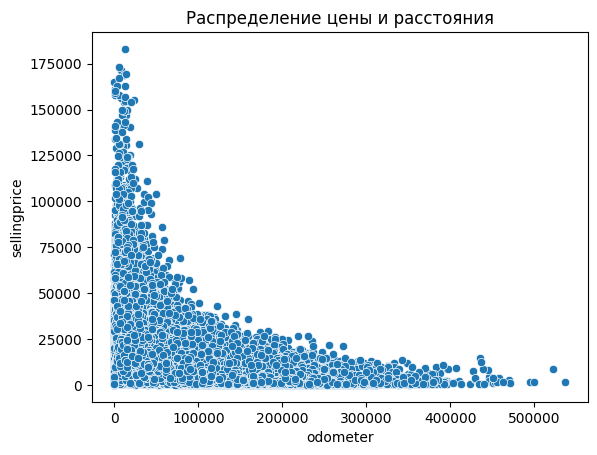

In [20]:
sns.scatterplot(x=df['odometer'],y=df['sellingprice']).set(title='Распределение цены и расстояния');

In [21]:
print(df['sellingprice'].quantile(0.75)+ 1.5*(df['sellingprice'].quantile(0.75)-df['sellingprice'].quantile(0.25)))

35150.0


Посмотрим, чем отличаются автомобили с ценой выше 35150 от остальных

In [22]:
df.query('sellingprice>35150').describe().compare(df.query('sellingprice<=35150').describe())

year                    condition                 \
               self          other          self          other   
count  12835.000000  427272.000000  12790.000000  417962.000000   
mean    2013.056019    2009.951108      4.261704       3.399757   
std        1.508656       3.992392      0.616062       0.946562   
min     2000.000000    1982.000000           NaN            NaN   
25%     2012.000000    2007.000000      4.000000       2.700000   
50%     2013.000000    2012.000000      4.400000       3.500000   
75%     2014.000000    2013.000000      4.800000       4.200000   
max             NaN            NaN           NaN            NaN   

            odometer                  sellingprice                 
                self          other           self          other  
count   12835.000000  427272.000000   12835.000000  427272.000000  
mean    23920.048617   69551.920341   45700.891001   12630.236028  
std     16751.005236   52599.821759   13645.753208    7767.683229  
min              NaN            NaN   35200.000000       1.000000  
25%     10817.000000   29261.750000   37700.000000    6600.000000  
50%     20643.000000   53735.000000   41250.000000   11900.000000  
75%     34240.000000  100829.000000   48050.000000   17500.000000  
max    159601.000000  537334.000000  183000.000000   35100.000000

Все разницы выглядят логичными. Автомобили с более высокой ценой в среднем были выпущены позже, пройденное расстояние меньше, в лучшем состоянии, по сравнению с автомобили с меньшей ценой. Можно сделать вывод, что данные автомобили не обладают аномальной ценой, но их количество невелико по сравнению с другими автомобилями, что также логично, так как рассматривается вторичный рынок.

In [23]:
df.query('sellingprice<100')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
137962,2003,Mercedes-Benz,E-Class,E500,Sedan,automatic,wdbuf70j73a269529,ga,2.1,1.0,black,black,peoples credit company inc,1,Tue Jan 06 2015 09:30:00 GMT-0800 (PST)


Есть автомобиль, у которога цена - 1 доллар. Скорее всего была заключена какая то сделка и цена была вставлена в качестве "заглушки". Стоит убрать этот автомобиль из датасета

In [24]:
df = df.drop(index=df['sellingprice'].idxmin())

Посмотрим на автомобили с пропуском в оценке качества

<AxesSubplot: >

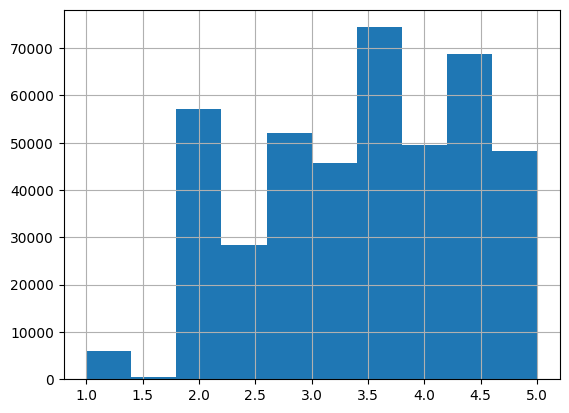

In [25]:
df['condition'].hist()

In [26]:
df.loc[df['condition'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
89,1999,mercedes,e300dt,NaN,NaN,automatic,wdbjf25h9xa799907,mi,NaN,219516.0,green,beige,warren toyota,400,Thu Dec 18 2014 13:10:00 GMT-0800 (PST)
122,2007,Suzuki,Reno,Base,Hatchback,automatic,kl5jd66z97k726834,il,NaN,127936.0,red,—,ray chevrolet inc,1800,Thu Dec 18 2014 14:00:00 GMT-0800 (PST)
298,2006,Chevrolet,Silverado 1500,LT3,Crew Cab,automatic,2gcek13t761205016,ne,NaN,231208.0,burgundy,gray,woodhouse ford inc,6000,Thu Dec 18 2014 11:00:00 GMT-0800 (PST)
303,2013,Kia,Sorento,LX,SUV,automatic,5xyktda60dg359259,il,NaN,31404.0,burgundy,—,world hyundai matteson,16500,Thu Dec 18 2014 10:00:00 GMT-0800 (PST)
326,2005,Jeep,Liberty,Sport,SUV,automatic,1j8gl48k25w621160,pa,NaN,102341.0,black,—,adcock brothers inc,4200,Fri Dec 19 2014 09:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439900,2001,Infiniti,I30,Base,Sedan,automatic,jnkca31a81t019350,az,NaN,194302.0,brown,brown,right honda,1300,Thu Dec 18 2014 11:00:00 GMT-0800 (PST)
439920,2013,Chevrolet,Silverado 1500,LT,Extended Cab,automatic,1gcrcse01dz410293,az,NaN,19431.0,black,black,yates buick gmc inc,22800,Thu Dec 18 2014 11:00:00 GMT-0800 (PST)
440145,2010,Mazda,Mazda3,s Grand Touring,Hatchback,automatic,jm1bl1h63a1137542,nj,NaN,104692.0,gray,—,d & d auto group llc,6650,Wed Dec 17 2014 09:30:00 GMT-0800 (PST)
440166,2005,Nissan,Maxima,3.5 SL,Sedan,automatic,1n4ba41e45c809875,fl,NaN,152938.0,gray,gray,gettel nissan of sarasota,2800,Thu Dec 18 2014 16:10:00 GMT-0800 (PST)


Заполним случайно пропуски, сохранив при этом доли оценок

In [27]:
random_state = 12345

In [28]:
np.random.seed(random_state)

In [29]:
def fill_condition():
    p = list(df['condition'].value_counts()/len(df.query('not condition.isnull()')))
    a = df['condition'].value_counts().index
    l = sum(df['condition'].isnull())
    df.loc[df['condition'].isnull(),'condition']=np.random.choice(a,l,p)

In [30]:
fill_condition()

<AxesSubplot: >

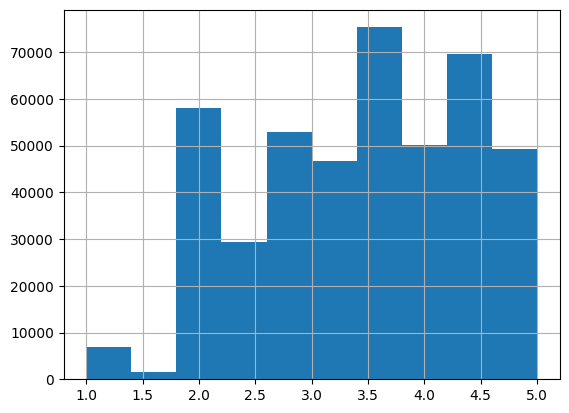

In [31]:
df['condition'].hist()

#### Категориальные признаки

Среди категориальных данных множество пропущенных значений

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440106 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440106 non-null  int64  
 1   make          432067 non-null  object 
 2   model         431987 non-null  object 
 3   trim          431776 non-null  object 
 4   body          429724 non-null  object 
 5   transmission  388675 non-null  object 
 6   vin           440106 non-null  object 
 7   state         440106 non-null  object 
 8   condition     440106 non-null  float64
 9   odometer      440106 non-null  float64
 10  color         439528 non-null  object 
 11  interior      439528 non-null  object 
 12  seller        440106 non-null  object 
 13  sellingprice  440106 non-null  int64  
 14  saledate      440106 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 53.7+ MB


In [33]:
df['odometer'] = df['odometer'].fillna(0)

In [34]:
print("Количество уникальных значений в make:",len(df['make'].unique()))
print("Количество уникальных значений в model:",len(df['model'].unique()))
print("Количество уникальных значений в body:",len(df['body'].unique()))
print("Количество уникальных значений в trim:",len(df['trim'].unique()))
print("Количество уникальных значений в seller:",len(df['seller'].unique()))

Количество уникальных значений в make: 93
Количество уникальных значений в model: 960
Количество уникальных значений в body: 86
Количество уникальных значений в trim: 1923
Количество уникальных значений в seller: 13017


Также присутсвует множество уникальных значений, что в дальнейшем может сильно усложнить обучение модели

Приведем столбцы к одинаковому виду

In [35]:
df['make'] = df['make'].str.lower()
df['trim'] = df['trim'].str.lower()
df['model'] = df['model'].str.lower()
df['body'] = df['body'].str.lower()
df['transmission'] = df['transmission'].str.lower()
df['seller'] = df['seller'].str.lower()
df['color'] = df['color'].str.lower()
df['interior'] = df['interior'].str.lower()

Так как пропусков очень много, их нельзя удалить. Поэтому заменим пропуски на категорию "uknown"

In [36]:
df['make'] = df['make'].fillna('uknown')
df['model'] = df['model'].fillna('uknown')
df['trim'] = df['trim'].fillna('uknown')
df['body'] = df['body'].fillna('uknown')
df['transmission'] = df['transmission'].fillna('uknown')
df['odometer'] = df['odometer'].fillna(0)
df['color'] = df['color'].fillna('uknown')
df['interior'] = df['interior'].fillna('uknown')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440106 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440106 non-null  int64  
 1   make          440106 non-null  object 
 2   model         440106 non-null  object 
 3   trim          440106 non-null  object 
 4   body          440106 non-null  object 
 5   transmission  440106 non-null  object 
 6   vin           440106 non-null  object 
 7   state         440106 non-null  object 
 8   condition     440106 non-null  float64
 9   odometer      440106 non-null  float64
 10  color         440106 non-null  object 
 11  interior      440106 non-null  object 
 12  seller        440106 non-null  object 
 13  sellingprice  440106 non-null  int64  
 14  saledate      440106 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 53.7+ MB


Пропуски полностью заполнены

Удалим столбец vin, так как он нам не пригодится

In [38]:
df = df.drop('vin',axis=1)

Сбросим индексы после удаления строк

In [39]:
df = df.reset_index(drop=True)

### Преобразование типов

#### Дата

In [40]:
df['saledate']

0         Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1         Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2         Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3         Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4         Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
                           ...                   
440101    Tue Jan 20 2015 04:30:00 GMT-0800 (PST)
440102    Wed Feb 11 2015 02:00:00 GMT-0800 (PST)
440103    Tue Mar 03 2015 04:30:00 GMT-0800 (PST)
440104    Wed Jan 14 2015 02:05:00 GMT-0800 (PST)
440105    Thu Jan 15 2015 02:00:00 GMT-0800 (PST)
Name: saledate, Length: 440106, dtype: object

In [41]:
df['date'] = pd.to_datetime(df['saledate'], format='%a %b %d %Y %H:%M:%S',exact=False)

In [42]:
df['date']

0        2015-06-02 02:30:00
1        2015-02-25 02:00:00
2        2015-06-10 02:30:00
3        2015-06-17 03:00:00
4        2015-02-03 04:00:00
                 ...        
440101   2015-01-20 04:30:00
440102   2015-02-11 02:00:00
440103   2015-03-03 04:30:00
440104   2015-01-14 02:05:00
440105   2015-01-15 02:00:00
Name: date, Length: 440106, dtype: datetime64[ns]

Выделим из даты данные, которые могу пригодится

In [43]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dow'] = df['date'].dt.day_of_week
df['hour']=df['date'].dt.hour
df['sale_year']=df['date'].dt.year

Удалим дату, так как теперь она не нужна

In [44]:
df = df.drop(['date','saledate'],axis=1)

#### Transmission

In [45]:
df['transmission'] = df['transmission'] == 'automatic'

In [46]:
df

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,month,day,dow,hour,sale_year
0,2011,ford,edge,sel,suv,True,md,4.2,111041.0,black,black,santander consumer,12500,6,2,1,2,2015
1,2014,ford,fusion,se,sedan,True,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2,25,2,2,2015
2,2012,nissan,sentra,2.0 sl,sedan,True,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,6,10,2,2,2015
3,2003,hummer,h2,base,suv,True,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,6,17,2,3,2015
4,2007,ford,fusion,sel,sedan,True,md,2.0,127709.0,black,black,purple heart,1300,2,3,1,4,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440101,2013,kia,optima,ex hybrid,sedan,True,ca,4.5,20434.0,white,beige,"kia motors america, inc",16000,1,20,1,4,2015
440102,2014,mini,cooper countryman,s all4,wagon,True,wi,2.9,14675.0,white,black,bmw mini financial services,24250,2,11,2,2,2015
440103,2008,bmw,6 series,650i,coupe,True,ca,3.7,102552.0,gray,black,studio city auto group,16750,3,3,1,4,2015
440104,2014,ram,2500,slt,crew cab,True,tx,3.0,29367.0,white,gray,express car & truck rental,33000,1,14,2,2,2015


In [47]:
df = df.drop_duplicates()

## Неявные дубликаты

Так как в категориальных признаках очень много уникальных данных, будет сложно вручную просмотреть их всех и выявить неявные дубликаты, поэтому пока оставим их

## Создание синтетических признаков

Возможно для модели пригодится возраст автомобиля - разница между годом продажи и годом выпуска

In [48]:
df['age'] = df['sale_year']-df['year']

Также может пригодится "интенсивность" - отношение пройденного расстояния к возрасту автомобиля может показать, насколько активно использовали автомобиль

In [49]:
def make_intense(row):
    if(row['age']>0):
        return row['odometer']/row['age']
    return row['odometer']

In [50]:
df['intense'] = df.apply(make_intense,axis=1)

## Анализ данных

In [51]:
#ProfileReport(df)

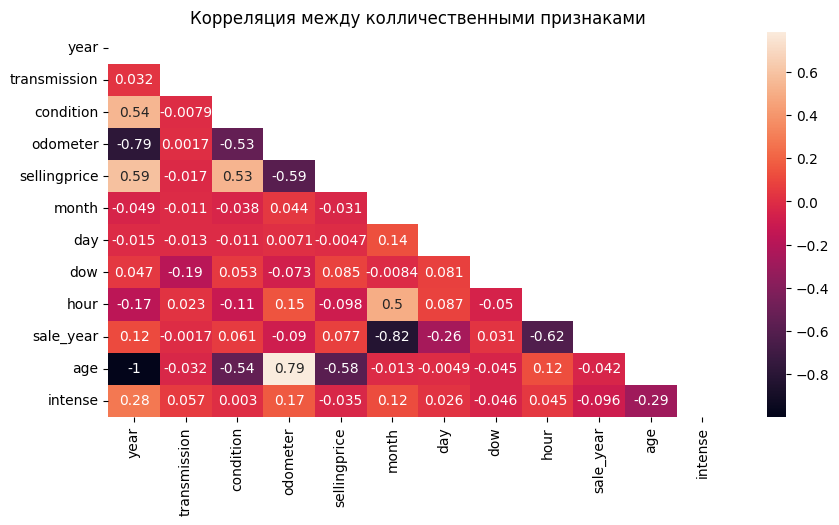

In [52]:
corr = df.corr()
matrix = np.triu(corr)

plt.figure(figsize=(10,5))
sns.heatmap(corr,mask=matrix,annot=True).set(title='Корреляция между колличественными признаками');
plt.show()

Исходя из матрицы корреляции можно сделать вывод, что целевой признак сильно коррелирует с: годом выпуска автомобиля, состоянием автомобиля, пройденным расстоянием и возрастом. При этом возраст линейно отрицательно коррелирует с годом производства. При использовании моделей линейной регрессии стоит убрать один из этих признаков, чтобы исключить мультиколлинеарность.

Для оценки влияния категориальных признаков на целевой признак, проведем однофакторный дисперсионный анализ

In [53]:
def create_fs(column_names):
    f_df = pd.DataFrame()
    for col in column_names:
        groups = [group['sellingprice'].values for name, group in df.groupby(col)]
        f_val, p_val = stats.f_oneway(*groups)
        f_df[col] = [f_val]
    f_df.index = ['F-val']
    return f_df

<AxesSubplot: >

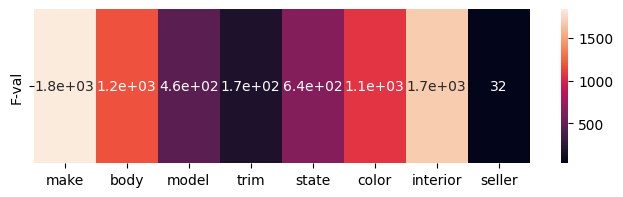

In [54]:
plt.figure(figsize=(8,2))
sns.heatmap(create_fs(['make','body','model','trim','state','color','interior','seller']),annot=True)

Исходя из F-значения, все категориальные признаки сильно влияют на цену автомобиля. Больше всего make - марка автомобиля, меньше всего seller - продавец (F-значения для make в 56 раз больше, чем для seller,в seller намного больше групп)

## Создание модели

Из-за большого количества категориальных признаков и большого количества уникальных значений в этих признаков не стоит использовать линейную регрессию. Поэтому будем использовать RandomForestRegressor или HistGradientBoostingRegressor

In [55]:
def generate_synthetic_data(df,target, target_threshold_start=20000,target_threshold_end=20000,count=500):
    df_majority = df[(df[target] <= target_threshold_start) | (df[target] >= target_threshold_end)]

    df_minority = df[(df[target] > target_threshold_start) & (df[target] < target_threshold_end)]


    synthetic_samples = max(0,count-len(df_minority))

    df_synthetic = df_minority.sample(n=synthetic_samples, replace=True, random_state=42)

    return df_synthetic

In [56]:
from sklearn.utils import shuffle

In [57]:
global_target_d = {}

После тренировки нескольких моделей было выявлено, что для некоторых категориальных признаков стоит применить Target encoding - замену их значений на средние значения целевого признака в их группе

In [58]:
def fill_target_encoding(column):
    if(column not in global_target_d):
        global_target_d[column] = {}
    def apply_encoding(v,column):
        if(v not in global_target_d[column]):
            global_target_d[column][v] = df[df[column]==v]['sellingprice'].mean()
            #global_target_d[column][v] = sum(df[column]==v)/len(df[column])
        return global_target_d[column][v]
    return df[column].apply(apply_encoding,column=column)

In [59]:
def target_encoding(column):
    def apply_encoding(v,column):
        if(v not in global_target_d[column]):
            return -1
        return global_target_d[column][v]
    return df[column].apply(apply_encoding,column=column)

In [60]:
df

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,month,day,dow,hour,sale_year,age,intense
0,2011,ford,edge,sel,suv,True,md,4.2,111041.0,black,black,santander consumer,12500,6,2,1,2,2015,4,27760.250000
1,2014,ford,fusion,se,sedan,True,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2,25,2,2,2015,1,31034.000000
2,2012,nissan,sentra,2.0 sl,sedan,True,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,6,10,2,2,2015,3,11873.000000
3,2003,hummer,h2,base,suv,True,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,6,17,2,3,2015,12,10941.750000
4,2007,ford,fusion,sel,sedan,True,md,2.0,127709.0,black,black,purple heart,1300,2,3,1,4,2015,8,15963.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440101,2013,kia,optima,ex hybrid,sedan,True,ca,4.5,20434.0,white,beige,"kia motors america, inc",16000,1,20,1,4,2015,2,10217.000000
440102,2014,mini,cooper countryman,s all4,wagon,True,wi,2.9,14675.0,white,black,bmw mini financial services,24250,2,11,2,2,2015,1,14675.000000
440103,2008,bmw,6 series,650i,coupe,True,ca,3.7,102552.0,gray,black,studio city auto group,16750,3,3,1,4,2015,7,14650.285714
440104,2014,ram,2500,slt,crew cab,True,tx,3.0,29367.0,white,gray,express car & truck rental,33000,1,14,2,2,2015,1,29367.000000


Подготовка признаков. После тренировки модели были удалены признаки, которые ухудшали результат

In [61]:
features_list = list(df.columns)
target_name = 'sellingprice'
features_list.remove('year')
features_list.remove('sale_year')
features_list.remove('transmission')
features_list.remove('hour')
features_list.remove('intense')
features_list.remove('sellingprice')

In [62]:
def data_trunc(df,column_name,threshold):
    c=df[column_name].value_counts()/(len(df))
    df[column_name].value_counts()
    def apply_func(v):
        return c[v]>threshold
    return df[column_name].apply(apply_func)



In [63]:
len(df)

440106

Основная проблема в датасете - множество комбинаций категориальных данных. После обучения модели есть большой шанс, что в валидационной выборке присутствуют автомобили с уникальной комбинацией категориальных признаков, из-за чего невозможно точно предсказать их цену. В дальнейшем будет показано, что с падением плотности объектов на графике растет дисперсия ошибки.

Одним из способ борьбы с этим, удалить уникальные комбинации из датасета, а именно удалить автомобили, у которых категориальные признаки являются "редкими" - их отношение к общему числу автомобилей меньше заданного значения (к примеру 0.2%)

In [64]:
#masks = []
#masks.append(data_trunc(df,'body',0.01))
#masks.append(data_trunc(df,'model',0.002))
#masks.append(data_trunc(df,'trim',0.002))

#mask = functools.reduce(operator.__and__,masks)
#df = df[mask]

In [65]:
len(df)

440106

In [66]:
df_train,df_valid = train_test_split(shuffle(df,random_state=42),test_size=0.25,random_state=random_state)

In [67]:
df_valid

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,month,day,dow,hour,sale_year,age,intense
377314,2013,dodge,challenger,sxt,coupe,True,tx,3.8,31287.0,white,black,tdaf remarketing,17000,2,4,2,2,2015,2,15643.500000
237146,2013,ford,fusion,se,sedan,True,ca,4.8,12563.0,black,black,"ford motor credit company,llc pd",15500,12,18,3,12,2014,1,12563.000000
14462,2014,kia,rio,lx,sedan,True,ga,4.1,23664.0,black,tan,kia motors finance,9900,6,18,3,3,2015,1,23664.000000
171013,2012,hyundai,sonata,gls,sedan,True,oh,4.3,34497.0,gray,gray,hyundai motor finance,11500,2,24,1,1,2015,3,11499.000000
174565,2015,kia,sportage,lx,suv,False,pa,4.9,9222.0,brown,gray,avis rent a car/barbush rentals,19200,5,22,4,2,2015,0,9222.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41812,2012,nissan,altima,2.5 s,sedan,True,il,2.8,23638.0,gray,black,nissan-infiniti lt,11200,1,22,3,2,2015,3,7879.333333
400912,2004,chrysler,sebring,touring,sedan,True,ga,1.9,173379.0,silver,black,automobile acceptance corp,1400,5,28,3,3,2015,11,15761.727273
246446,2012,nissan,altima,2.5 s,sedan,True,mo,3.9,46335.0,blue,black,nissan-infiniti lt,13100,1,21,2,2,2015,3,15445.000000
128189,2009,mercedes-benz,sl-class,sl550,convertible,True,fl,5.0,44940.0,black,black,cire leasing,38100,6,2,1,2,2015,6,7490.000000


In [68]:
#df_train1 = generate_synthetic_data(df_train,'sellingprice',30_000,50_000,100_000)
#df_train2 = generate_synthetic_data(df_train,'sellingprice',50_000,75_000,50_000)
#df_train3 = generate_synthetic_data(df_train,'sellingprice',75_000,150_000,20_000)

#df_train = pd.concat([df_train1,df_train2,df_train3,df_train])

#del df_train1
#del df_train2
#del df_train3

#df_train = shuffle(df_train,random_state=random_state)

Target encoding четырех признаков

In [69]:
df_train['make'] = fill_target_encoding('make')
df_train['model'] = fill_target_encoding('model')
df_train['body'] = fill_target_encoding('body')
df_train['state'] = fill_target_encoding('state')

In [70]:
df_train['make'] = target_encoding('make')
df_train['model'] = target_encoding('model')
df_train['body'] = target_encoding('body')
df_train['state'] = target_encoding('state')

In [71]:
df_valid['make'] = target_encoding('make')
df_valid['model'] = target_encoding('model')
df_valid['body'] = target_encoding('body')
df_valid['state'] = target_encoding('state')

In [72]:
df['make'] = target_encoding('make')
df['model'] = target_encoding('model')
df['body'] = target_encoding('body')
df['state'] = target_encoding('state')

In [73]:
features = df_train[features_list]
target = df_train[target_name]

In [74]:
#features_train,features_valid,target_train,target_valid = train_test_split(features,target,test_size=0.25,random_state=random_state)
#features_train = features_train.reset_index(drop=True)
#features_valid = features_valid.reset_index(drop=True)
#target_train = target_train.reset_index(drop=True)
#target_valid = target_valid.reset_index(drop=True)

In [75]:
df_train = df_train.reset_index()

После тренировки модели с использованием RandomizedSearchCV были выявлены лучшие гиперпараметры для модели

In [76]:
model = RandomForestRegressor(random_state=12345,n_estimators=600,max_depth=80,min_samples_split=3,min_samples_leaf=3,n_jobs=-1)
#model = CatBoostRegressor(random_seed=12345,thread_count=-1,cat_features=[0,1,2,3,4,7,8,9],loss_function='MAE',iterations=100,learning_rate=0.15,depth=16,max_ctr_complexity=12)
cat_features = features_list.copy()
for b in ['odometer','age','body','make','model','state','condition','month','dow','day']:
    cat_features.remove(b)


ct = ColumnTransformer(
    [
        ('le',preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),cat_features),
    ],remainder='passthrough'
)
pipe_model = Pipeline(
    steps=[
        ('label',ct),
        ('mymodel',model)
    ]
)
features = df_train[features_list]
target = df_train[target_name]
pipe_model.fit(features,target)
print('done')

done


Результаты на валидационной выборке

In [78]:
features = df_valid[features_list]
target = df_valid[target_name]
predictions = pipe_model.predict(features)
print(f'MAE:{mean_absolute_error(target,predictions)}')
print(f'MAPE:{mean_absolute_percentage_error(target,predictions)}')

MAE:1224.6654005115113
MAPE:0.1766436521174835


Результаты на тренировочной выборке

In [79]:
features = df_train[features_list]
target = df_train[target_name]
predictions = pipe_model.predict(features)
print(f'MAE:{mean_absolute_error(target,predictions)}')
print(f'MAPE:{mean_absolute_percentage_error(target,predictions)}')

MAE:674.367152611102
MAPE:0.09428819202529443


Как было отмечено ранее, низкая плотность объектов с высокой ценой приводит к увеличению дисперсии ошибки, соотвенственно и к увеличению средней ошибки

In [80]:
mask = target>50_000
print("> 50_000",mean_absolute_error(target[mask], pipe_model.predict(features[mask])))
mask = (target>15_000) & (target < 50_000)
print("> 15_000 and < 50_000",mean_absolute_error(target[mask], pipe_model.predict(features[mask])))
mask = target<15_000
print("< 15_000",mean_absolute_error(target[mask], pipe_model.predict(features[mask])))

> 50_000 3736.068091896099
> 15_000 and < 50_000 871.5535807505736
< 15_000 535.6259181923907


Посмотрим на график ошибки

1224.6654005114924


<AxesSubplot: xlabel='sellingprice', ylabel='sellingprice'>

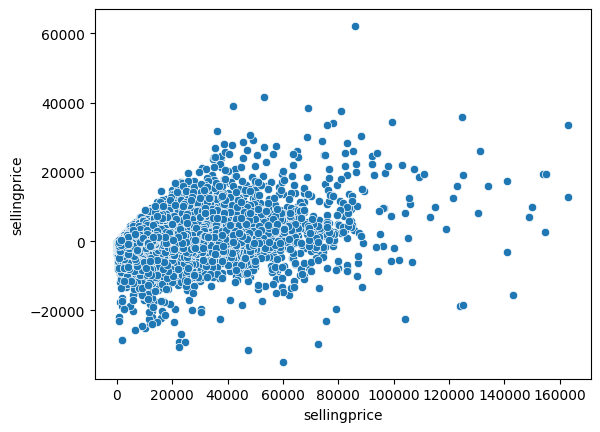

In [81]:
df_valid = df_valid.reset_index(drop=True)
features = df_valid[features_list]
target = df_valid[target_name]
predictions = pipe_model.predict(features)

y_true = target
y_pred = predictions

err = y_true - y_pred
print(sum(abs(err))/len(err))
sns.scatterplot(x=y_true,y=err)

Коэффициент детерминации высокий, что может свидетельствовать о хорошей модели и еще раз подтвердить, что проблема в данных, а не в их подготовке

In [77]:
features = df_valid[features_list]
target = df_valid[target_name]
print(f'R2:{r2_score(target,pipe_model.predict(features))}')

R2:0.9539834446657048


In [103]:
def get_importance():
    imp = []
    for feat, importance in zip(pipe_model['label'].get_feature_names_out(), model.feature_importances_):
        feat = feat.replace('remainder__','')
        feat = feat.replace('le__','')
        imp.append([feat,importance])
    return pd.DataFrame(data=imp,columns=['feature','importance'])

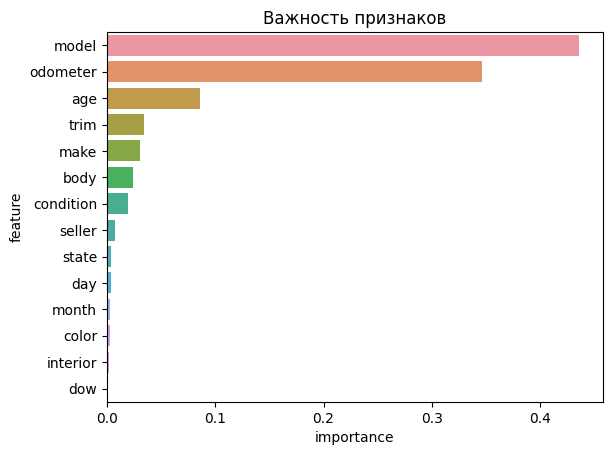

In [108]:
sns.barplot(data=get_importance().sort_values(by='importance',ascending=False),y='feature',x='importance',orient='h').set(title='Важность признаков');

Исходя из графика следует, что самыми важными признаками являются: модель, пройденное расстоние и возраст автомобиля. Меньше всего влияют на цену день недели покупки, цвет салона и автомобиля

Также можно убедиться в адекватности модели, сравнив предсказания с подстановкой среднего значения цены

In [78]:
features = df_valid[features_list]
target = df_valid[target_name]
target_train = df_train[target_name].mean()
mean_val = [target_train.mean()]*len(target)
print(f'MAE:{mean_absolute_error(target,mean_val)}')

MAE:7125.204072997963


Модель действительно предсказывает, а не угадывает. Ошибка модели более чем в 5 раз меньше, чем у среднего значения

In [110]:
len(df_valid)

110027